# Importing Lib



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/content/ALL_FAIL_LOG_GPS_0.csv')

# preprocessing and exploring data



In [ ]:
print("Dataset Shape:", data.shape)
print("\nColumns:\n", data.columns)
print("\nSample Data:\n", data.head())
print("\nMissing Values:\n", data.isnull().sum())

Dataset Shape: (21597, 17)

Columns:
 Index(['LineNo', 'abTimeUS', 'abI', 'abGyrX', 'abGyrY', 'abGyrZ', 'abAccX',
       'abAccY', 'abAccZ', 'abEG', 'abEA', 'abT', 'abGH', 'abAH', 'abGHz',
       'abAHz', 'labels'],
      dtype='object')

Sample Data:
    LineNo   abTimeUS  abI    abGyrX    abGyrY     abGyrZ    abAccX    abAccY  \
0   14707   47623443    0  0.000652  0.000699   0.000664 -0.001625 -0.000529   
1  294758  359383689    0  3.323413 -5.883018  -6.913023  0.528758 -1.198488   
2  288150  352023301    0  4.783490 -6.518798 -28.446280 -0.080333 -0.054142   
3  265078  326383561    0  1.152616 -2.402375  -0.117582 -0.328573  0.036870   
4  105572  148903748    0  1.405822 -2.136524   0.033208 -5.092781 -0.064265   

      abAccZ  abEG  abEA       abT  abGH  abAH  abGHz  abAHz  labels  
0  -9.817689     0     0  27.83643     1     1   1000   1000       0  
1  -6.869982     0     0  38.92860     1     1    999    999       3  
2  -8.466424     0     0  38.77781     1     1    999

In [ ]:
print("\nData Types:\n", data.dtypes)


Data Types:
 LineNo        int64
abTimeUS      int64
abI           int64
abGyrX      float64
abGyrY      float64
abGyrZ      float64
abAccX      float64
abAccY      float64
abAccZ      float64
abEG          int64
abEA          int64
abT         float64
abGH          int64
abAH          int64
abGHz         int64
abAHz         int64
labels        int64
dtype: object


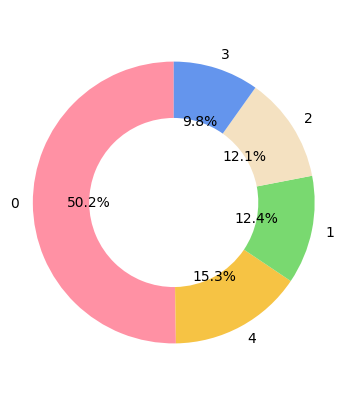

In [126]:
# if 'labels' in data.columns:
#     label_counts = data['labels'].value_counts()
#     # Define specific colors for 5 labels
#     colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]
#     # Plot the pie chart
#     plt.figure(figsize=(4, 5))
#     plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
#     plt.axis('equal')
#     plt.show()
if 'labels' in data.columns:
    label_counts = data['labels'].value_counts()
    # Define specific colors for 5 labels
    colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]

    # Plot the donut chart
    plt.figure(figsize=(4, 5))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'width': 0.4})
    plt.axis('equal')
    plt.show()



In [ ]:
# Encoding Categorical Data
if 'labels' in data.columns:
    label_encoder = LabelEncoder()
    data['labels'] = label_encoder.fit_transform(data['labels'])
    print("\nLabel Encoding Complete. Classes:", label_encoder.classes_)


Label Encoding Complete. Classes: [0 1 2 3 4]


In [ ]:
# Feature Selection
X = data.drop(columns=['labels']).values  # Features
y = data['labels'].values  # Target

In [ ]:
X.shape

(21597, 16)

In [ ]:
# Scaling Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=len(np.unique(y)))

In [ ]:
# Reshaping for TCN (samples, time_steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [ ]:
X_reshaped.shape

(21597, 1, 16)



---

#K fold Cross validation

---



# Model

In [ ]:
# Define the TCN Block
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

In [ ]:
# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

In [ ]:
# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # TCN Layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model


In [ ]:
# Input shape for TCN
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])
num_classes = y_encoded.shape[1]

In [ ]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuraciesKF = []
label_accuraciesKF = []

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_foldKF, X_val_foldKF = X_reshaped[train_index], X_reshaped[val_index]
    y_train_foldKF, y_val_foldKF = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    modelKF = build_tcn_attention_model(input_shape, num_classes)
    modelKF.fit(X_train_foldKF, y_train_foldKF, epochs=50, batch_size=32, verbose=0, validation_data=(X_val_foldKF, y_val_foldKF))

    # Evaluate the model
    lossKF, accuracyKF = modelKF.evaluate(X_val_foldKF, y_val_foldKF, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracyKF:.4f}")
    accuraciesKF.append(accuracyKF)

    # Predictions
    y_predKF = modelKF.predict(X_val_foldKF)
    y_pred_classesKF = np.argmax(y_predKF, axis=1)
    y_true_classesKF = np.argmax(y_val_foldKF, axis=1)

    # Accuracy per label
    label_accKF = []
    for label in range(num_classes):
        label_indicesKF = (y_true_classesKF == label)
        label_accKF.append(accuracy_score(y_true_classesKF[label_indicesKF], y_pred_classesKF[label_indicesKF]))
    label_accuraciesKF.append(label_accKF)

    fold_no += 1

modelKF.summary()


Training fold 1...
Validation Accuracy for fold 1: 0.9655
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Training fold 2...
Validation Accuracy for fold 2: 0.9771
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Training fold 3...
Validation Accuracy for fold 3: 0.9636
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Training fold 4...
Validation Accuracy for fold 4: 0.9715
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training fold 5...
Validation Accuracy for fold 5: 0.9778
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 1, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 1, 64)               │           3,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_14 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_4 (AttentionLayer)   │ (None, 64)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,705 (385.57 KB)

 Trainable params: 32,773 (128.02 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 65,548 (256.05 KB)

In [ ]:
# Calculate average accuracy
average_accuracyKF = np.mean(accuraciesKF)
print(f"\nAverage Accuracy across all folds: {average_accuracyKF:.4f}")


Average Accuracy across all folds: 0.9711


In [ ]:
# Average accuracy per label
label_accuraciesKF = np.mean(label_accuraciesKF, axis=0)
for idx, acc in enumerate(label_accuraciesKF):
    print(f"Label {idx} Accuracy: {acc:.4f}")

Label 0 Accuracy: 0.9802
Label 1 Accuracy: 0.9594
Label 2 Accuracy: 0.9589
Label 3 Accuracy: 0.9454
Label 4 Accuracy: 0.9791


In [ ]:
# Evaluate the last fold predictions
y_predKF = modelKF.predict(X_val_foldKF)
y_pred_classesKF = np.argmax(y_predKF, axis=1)
y_true_classesKF = np.argmax(y_val_foldKF, axis=1)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classesKF, y_pred_classesKF,digits = 4))


Classification Report:

              precision    recall  f1-score   support

           0     0.9848    0.9676    0.9761      2006
           1     0.9539    0.9981    0.9755       539
           2     0.9524    0.9873    0.9695       628
           3     0.9974    0.9499    0.9730       399
           4     0.9894    0.9973    0.9933       747

    accuracy                         0.9778      4319
   macro avg     0.9756    0.9800    0.9775      4319
weighted avg     0.9782    0.9778    0.9778      4319



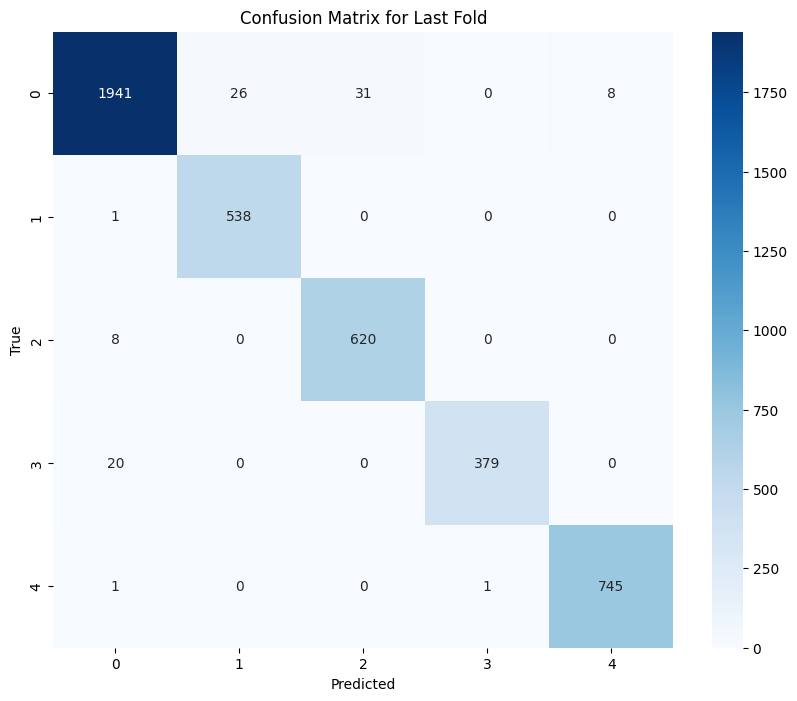

In [ ]:
# Confusion Matrix
conf_matrixKF = tf.math.confusion_matrix(y_true_classesKF, y_pred_classesKF)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrixKF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix for Last Fold')
plt.show()


Label Distribution:
 labels
0    10147
4     3440
2     3092
1     2846
3     2072
Name: count, dtype: int64


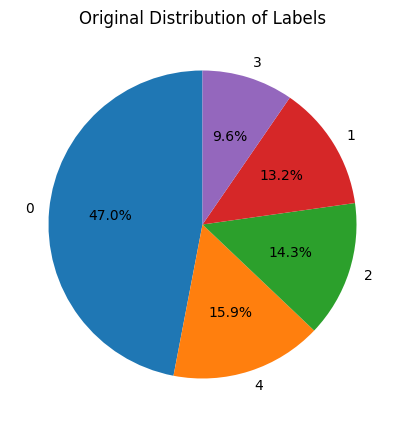

In [ ]:
if 'labels' in data.columns:
    label_countsKF = data['labels'].value_counts()
    print("\nLabel Distribution:\n", label_countsKF)
    plt.figure(figsize=(5, 5))
    plt.pie(label_countsKF, labels=label_countsKF.index, autopct='%1.1f%%', startangle=90)
    plt.title('Original Distribution of Labels')
    plt.show()

In [ ]:
# Get the predicted labels after training (from the last fold or the final model)
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)
class_counts = pd.Series(y_pred_classes).value_counts()
print(class_counts)
# Plot pie chart of predicted labels
plt.figure(figsize=(8, 8))
plt.pie(pd.Series(y_pred_classes).value_counts(), labels=label_encoder.classes_, autopct='%1.1f%%', startangle=90)
plt.title('Label Distribution of Predictions After Training')
plt.show()

NameError: name 'X_val_fold' is not defined



---

#Early Stopping

---



In [ ]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuraciesES = []
label_accuraciesES = []

from tensorflow.keras.callbacks import EarlyStopping

# Add Early Stopping to the training process
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_foldES, X_val_foldES = X_reshaped[train_index], X_reshaped[val_index]
    y_train_foldES, y_val_foldES = y_encoded[train_index], y_encoded[val_index]
    # Build and train the model
    modelES = build_tcn_attention_model(input_shape, num_classes)
    modelES.fit(X_train_foldES, y_train_foldES, epochs=50, batch_size=32, verbose=0,
              validation_data=(X_val_foldES, y_val_foldES), callbacks=[early_stopping])

    # Evaluate the model
    lossES, accuracyES = modelES.evaluate(X_val_foldES, y_val_foldES, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracyES:.4f}")
    accuraciesES.append(accuracyES)

    fold_no += 1




Training fold 1...
Validation Accuracy for fold 1: 0.7066

Training fold 2...
Validation Accuracy for fold 2: 0.4873

Training fold 3...
Validation Accuracy for fold 3: 0.4867

Training fold 4...
Validation Accuracy for fold 4: 0.4528

Training fold 5...
Validation Accuracy for fold 5: 0.7846


In [ ]:
modelES.summary()

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_48 (InputLayer)          │ (None, 1, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_36 (Sequential)           │ (None, 1, 64)               │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_37 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_38 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_12 (AttentionLayer)  │ (None, 64)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,521 (365.32 KB)

 Trainable params: 31,045 (121.27 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 62,092 (242.55 KB)

In [ ]:
# Calculate average accuracy
average_accuracyES = np.mean(accuraciesES)
print(f"\nAverage Accuracy across all folds: {average_accuracyES:.4f}")


Average Accuracy across all folds: 0.5836


In [ ]:
# Average accuracy per label
label_accuraciesES = np.mean(label_accuraciesES, axis=0)
for idx, acc in enumerate(label_accuraciesES):
    print(f"Label {idx} Accuracy: {acc:.4f}")

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TypeError: 'numpy.float64' object is not iterable

In [ ]:
# Evaluate the last fold predictions
y_predES = modelES.predict(X_val_foldES)
y_pred_classesES = np.argmax(y_predES, axis=1)
y_true_classesES = np.argmax(y_val_foldES, axis=1)

In [ ]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classesES, y_pred_classesES,digits = 4))

In [ ]:
# Confusion Matrix
conf_matrixES = tf.math.confusion_matrix(y_true_classesES, y_pred_classesES)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrixES, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Last Fold')
plt.show()

In [ ]:
if 'labels' in data.columns:
    label_countsES = data['labels'].value_counts()
    print("\nLabel Distribution:\n", label_countsES)
    plt.figure(figsize=(5, 5))
    plt.pie(label_countsES, labels=label_countsWS.index, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Labels')
    plt.show()

In [ ]:
# Get the label distribution after training
# Get the predicted labels after training
class_countsES = pd.Series(y_pred_classesES).value_counts()
print(class_countsES)
# Plot pie chart of predicted labels
plt.figure(figsize=(5, 5))
plt.pie(pd.Series(y_pred_classesES).value_counts(), labels=label_encoderES.classes_, autopct='%1.1f%%', startangle=90)
plt.title('Label Distribution of Predictions After Training')
plt.show()



---

L2 Regularization

---



In [ ]:
from tensorflow.keras.regularizers import l2

# Update TCN_Block to include L2 Regularization
def TCN_Block_with_L2(filters, kernel_size, dilation_rate, l2_reg=0.01):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal',
               dilation_rate=dilation_rate, kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Activation('relu')
    ])

# Define the TCN with Attention Model with L2 Regularization
def build_tcn_attention_model_with_L2(input_shape, num_classes, l2_reg=0.01):
    inputs = Input(shape=input_shape)

    # TCN Layers with L2 Regularization
    x = TCN_Block_with_L2(filters=64, kernel_size=3, dilation_rate=4, l2_reg=l2_reg)(inputs)
    x = TCN_Block_with_L2(filters=64, kernel_size=3, dilation_rate=8, l2_reg=l2_reg)(x)
    x = TCN_Block_with_L2(filters=64, kernel_size=3, dilation_rate=16, l2_reg=l2_reg)(x)

    # Attention mechanism
    attention_output = AttentionLayer()(x)

    # Classification with L2 Regularization
    classification = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg))(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model

L2



---

Dropout

---




In [ ]:
from tensorflow.keras.layers import Dropout

# Update TCN_Block to include Dropout
def TCN_Block(filters, kernel_size, dilation_rate, dropout_rate=0.3):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate)
    ])

# Define the TCN with Attention Model with Dropout
def build_tcn_attention_model_with_dropout(input_shape, num_classes, dropout_rate=0.3):
    inputs = Input(shape=input_shape)

    # TCN Layers with Dropout
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4, dropout_rate=dropout_rate)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8, dropout_rate=dropout_rate)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16, dropout_rate=dropout_rate)(x)

    # Attention mechanism
    attention_output = AttentionLayer()(x)

    # Classification with Dropout
    dropout_output = Dropout(dropout_rate)(attention_output)
    classification = Dense(num_classes, activation='softmax')(dropout_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model

DP